# `doubleml` with simulated data

First we'll reuse that code to generate a simulated causal dataset

In [172]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import uniform, normal, binomial, choice

import graphviz as gr
import pandas as pd

def simulate(**kwargs):
  """Helper function to simulate and plot a causal function"""
  values = {}
  g = gr.Digraph()
  for k,v in kwargs.items():
    parents = v.__code__.co_varnames
    inputs = {arg: values[arg] for arg in parents}
    values[k] = v(**inputs)
    for p in parents:
        g.edge(p,k)
  data = pd.DataFrame(values)
  return data, g

,age,degree,income
0,39.981605,3,105607.272102
1,63.028572,2,122171.414700
2,54.279758,2,113208.865174
3,48.946339,3,114428.811783
4,31.240746,2,91017.282832


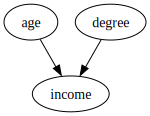

In [173]:
np.random.seed(42)

N = 156

df, g = simulate(
    age = lambda: uniform(25, 65, N),
    degree = lambda: choice(range(4), N),
    income = lambda age, degree: normal(50000 + (1000 * age) + (5000 * degree), 1000)
)
display(df.head())
g

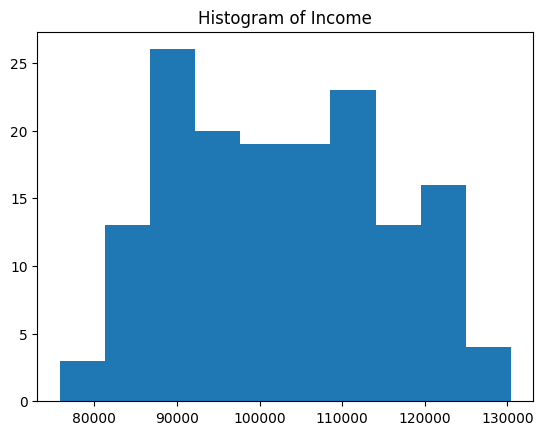

In [174]:
plt.hist(df.income)
plt.title("Histogram of Income");

## Examples with OLS

In [175]:
X = sm.add_constant(df[['age', 'degree']])
y = df['income']

mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.309e+04
Date:                Thu, 04 Jan 2024   Prob (F-statistic):          9.40e-172
Time:                        12:52:01   Log-Likelihood:                -1295.0
No. Observations:                 156   AIC:                             2596.
Df Residuals:                     153   BIC:                             2605.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.031e+04    332.695    151.205      0.000    4.96e+04     5.1e+04
age          993.5762      6.651    149.378      0.000     980.436    1006.717
degree      5024.5224     69.119     72.693      0.000    4887.971    5161.074
==============================================================================
Omnibus:                        5.421   Durbin-Watson:                   2.195
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                7.607
Skew:                           0.112   Prob(JB):                       0.0223
Kurtosis:                       4.058   Cond. No.                         193.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this simple case there are no confounders and the simulated coefficients are covered by OLS under these parameters. If we were to increase the error around income our estimate gets worse.

What happens if we omit a variable?

In [176]:
# omitted variable
X = sm.add_constant(df[['degree']])
y = df['income']

mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     26.44
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           8.17e-07
Time:                        12:52:01   Log-Likelihood:                -1684.2
No. Observations:                 156   AIC:                             3372.
Df Residuals:                     154   BIC:                             3379.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.525e+04   1714.031     55.573      0.000    9.19e+04    9.86e+04
degree      4281.2542    832.684      5.142      0.000    2636.297    5926.211
==============================================================================
Omnibus:                       87.052   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.027
Skew:                           0.179   Prob(JB):                      0.00403
Kurtosis:                       1.748   Cond. No.                         4.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see here we get a much wider confidence interval around the impact of degree on income, but it's at least covered in the interval

## Confounder

Now let's add a confounder `ability` that impacts both degree and income

,ability,age,degree,income
0,0,39.338629,0,89843.616421
1,1,29.634762,4,103500.517575
2,0,59.524137,0,108323.840628
3,0,49.931925,3,114597.423837
4,0,38.235921,2,97760.975683


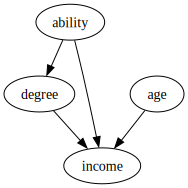

In [177]:
# Simulate dataset in which a confounder exists

np.random.seed(42)

N = 156 # same as previous

df, g = simulate(
    ability = lambda: choice(range(2), N),
    age = lambda: uniform(25, 65, N),
    degree = lambda ability: choice(range(4), N) + ability,
    income = lambda age, degree, ability: normal(50000 + (5000 * degree) + (1000 * age) + (3000 * ability), 1000)
)
display(df.head())
g

In [178]:
# Using OLS we can control for this confounder:
X = sm.add_constant(df[['degree', 'age', 'ability']])
y = df['income']

mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     8853.
Date:                Thu, 04 Jan 2024   Prob (F-statistic):          2.42e-170
Time:                        12:52:01   Log-Likelihood:                -1289.8
No. Observations:                 156   AIC:                             2588.
Df Residuals:                     152   BIC:                             2600.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.009e+04    356.174    140.633      0.000    4.94e+04    5.08e+04
degree      4982.9587     68.759     72.470      0.000    4847.111    5118.806
age         1002.1224      6.775    147.920      0.000     988.738    1015.507
ability     2834.0546    164.203     17.259      0.000    2509.640    3158.469
==============================================================================
Omnibus:                        0.366   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.833   Jarque-Bera (JB):                0.211
Skew:                          -0.087   Prob(JB):                        0.900
Kurtosis:                       3.047   Cond. No.                         216.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since we control for the confounder, we'll get a good estimate for the impact of `degree` on `income` in this simulated dataset. What if we don't control for it?

In [179]:
# What happens if we omit the confounder?
X = sm.add_constant(df[['degree', 'age']])
y = df['income']

mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     4466.
Date:                Thu, 04 Jan 2024   Prob (F-statistic):          2.09e-136
Time:                        12:52:01   Log-Likelihood:                -1374.4
No. Observations:                 156   AIC:                             2755.
Df Residuals:                     153   BIC:                             2764.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.074e+04    607.330     83.546      0.000    4.95e+04    5.19e+04
degree      5405.1677    110.193     49.052      0.000    5187.472    5622.863
age         1001.4429     11.617     86.205      0.000     978.492    1024.393
==============================================================================
Omnibus:                       12.591   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                4.739
Skew:                          -0.064   Prob(JB):                       0.0935
Kurtosis:                       2.156   Cond. No.                         214.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this case, without controlling for the confounder, we have a slightly biased estimate of the effect on income due to degree - and note that the confidence interval doesn't include the true value anymore

## DoubleML

Using our toy data with simulated confounder, we can partial out the effect of the confounder using ML using the double/debiased machine learning implementation in `DoubleML`:

### Partial Linear Regression

**Partially linear regression (PLR)** models take the form

$$
\begin{aligned}
    Y &= D \theta_0 + g_0(X) + \zeta, & &\mathbb{E}(\zeta | D,X) = 0,\\
    D &= m_0(X) + V, & &\mathbb{E}(V | X) = 0,
\end{aligned}
$$

where $Y$ is the outcome variable and $D$ is the policy variable of interest.
The high-dimensional vector $X = (X_1, \ldots, X_p)$ consists of other confounding covariates,
and $\zeta$ and $V$ are stochastic errors.

* `ml_l`: $\ell_0(X) = E[Y|X]$
* `ml_m`: $m_0(X) = E[D|X]$

In [180]:
import doubleml as dml
from sklearn.base import clone
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

# Specify the causal variables here
data_dml = dml.DoubleMLData(df,
                            y_col = 'income',               # outcome
                            d_cols = 'degree',              # treatment
                            x_cols = ['age', 'ability'])    # covariates

# Models - linear regression
ridge_model = Ridge(alpha=0.9)
ml_l_lin_reg = clone(ridge_model)  # Model E[Y|X]
ml_m_lin_reg = clone(ridge_model)  # Model E[D|X]

# Models - random forest
rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, min_samples_split=6)
ml_l_rf = clone(rf_model)
ml_m_rf = clone(rf_model)

In [181]:
np.random.seed(42)

# Instantiate partial linear regression
dml_plr_lin_reg = dml.DoubleMLPLR(data_dml,
                                  ml_l = ml_l_lin_reg,
                                  ml_m = ml_m_lin_reg,
                                  n_folds=5)

# fit and print summary
dml_plr_lin_reg.fit(store_predictions = True)
display(dml_plr_lin_reg.summary)

,coef,std err,t,P>|t|,2.5 %,97.5 %
degree,4955.344503,70.924322,69.868056,0.0,4816.335386,5094.35362


In [182]:
np.random.seed(42)

# Instantiate partial linear regression with RF
dml_plr_rf = dml.DoubleMLPLR(data_dml,
                                  ml_l = ml_l_rf,
                                  ml_m = ml_m_rf, 
                                  n_folds=5)

dml_plr_rf.fit(store_predictions = True)
display(dml_plr_rf.summary)

,coef,std err,t,P>|t|,2.5 %,97.5 %
degree,4811.67661,115.273727,41.741312,0.0,4585.744256,5037.608963


In both cases we get close to the true value again but we still need to control for the confounder to get an unbiased estimate of our decision variable. 

## So why use DoubleML?

So when would you use DoubleML? You'd use it when there is perhaps some nonlinear relationship between $X$ and $Y$ and/or between $X$ and $D$.

,ability,age,degree,income
0,6,52.697441,7,156198.868073
1,3,35.776493,3,110837.131931
2,7,34.765021,8,184596.046063
3,4,31.731642,5,117863.557462
4,6,33.750569,7,136205.531168


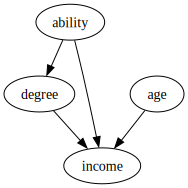

In [197]:
# Simulate a confounder that acts nonlinearly with both Degree and Income
np.random.seed(42)

N = 156 # same as previous 

df, g = simulate(
    ability = lambda: choice(range(10), N),
    age = lambda: uniform(25, 65, N),
    degree = lambda ability: choice(range(4), N) + ability,
    income = lambda age, degree, ability: normal(50000 + (5000 * degree) + (1000 * age) + (3000 * ability), 1000)
)
ability_adder = [39500 if i > 6 else 0 for i in df['ability'] ]
df['income'] = df['income'] + ability_adder
display(df.head())
g

In [198]:
# Using OLS we can control for this confounder:
X = sm.add_constant(df[['degree', 'age', 'ability']])
y = df['income']

mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     628.1
Date:                Thu, 04 Jan 2024   Prob (F-statistic):           2.12e-85
Time:                        12:54:24   Log-Likelihood:                -1676.9
No. Observations:                 156   AIC:                             3362.
Df Residuals:                     152   BIC:                             3374.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.306e+04   4344.729      9.911      0.000    3.45e+04    5.16e+04
degree      4360.7761    800.475      5.448      0.000    2779.282    5942.270
age          907.5396     81.996     11.068      0.000     745.541    1069.538
ability     8904.5372    895.448      9.944      0.000    7135.405    1.07e+04
==============================================================================
Omnibus:                       38.190   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.676
Skew:                          -0.498   Prob(JB):                      0.00107
Kurtosis:                       1.946   Cond. No.                         225.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [199]:
# Specify the causal variables here
data_dml = dml.DoubleMLData(df,
                            y_col = 'income',               # outcome
                            d_cols = 'degree',              # treatment
                            x_cols = ['age', 'ability'])           # covariates

# Models - linear regression
ridge_model = Ridge(alpha=0.9)
ml_l_lin_reg = clone(ridge_model)  # Model E[Y|X]
ml_m_lin_reg = clone(ridge_model)  # Model E[D|X]

# Models - random forest
rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, min_samples_split=6)
ml_l_rf = clone(rf_model)
ml_m_rf = clone(rf_model)

np.random.seed(42)

# Instantiate partial linear regression
dml_plr_lin_reg = dml.DoubleMLPLR(data_dml,
                                  ml_l = ml_l_lin_reg,
                                  ml_m = ml_m_lin_reg,
                                  n_folds=5)

# fit and print summary
dml_plr_lin_reg.fit(store_predictions = True)
display(dml_plr_lin_reg.summary)

,coef,std err,t,P>|t|,2.5 %,97.5 %
degree,4379.69607,788.217213,5.556458,2.753035e-08,2834.81872,5924.573419


In [200]:
np.random.seed(42)

# Instantiate partial linear regression with RF
dml_plr_rf = dml.DoubleMLPLR(data_dml,
                                  ml_l = ml_l_rf,
                                  ml_m = ml_m_rf, 
                                  n_folds=5)

dml_plr_rf.fit(store_predictions = True)
display(dml_plr_rf.summary)

,coef,std err,t,P>|t|,2.5 %,97.5 %
degree,5239.888069,212.769853,24.627023,6.488257e-134,4822.86682,5656.909319


Here we get a better estimate of the impact of degree with the random forest model!